In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [228]:
# Load data
train = pd.read_csv('data/training.csv')
test, validation = train_test_split(pd.read_csv('data/testing.csv'), test_size = .5)

print(f"{len(train)} training samples, {len(test)} test samples, {len(validation)} validation samples")
print("\nColumns:")
print(', '.join(data_train.columns))

120793 training samples, 15099 test samples, 15100 validation samples

Columns:
track_id, album_id, track_number, track_count, duration, explicit, track_pop, album_pop, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, comparative_pop


In [243]:
# Regularize
# Create a scaler
scaler = MinMaxScaler(feature_range=(-1,1))

# Fit scaler on data
no_id_train = train.drop(['track_id', 'album_id', 'album_pop', 'track_pop'], axis=1)
no_id_test = test.drop(['track_id', 'album_id','album_pop', 'track_pop'], axis=1)
no_id_validation = validation.drop(['track_id', 'album_id','album_pop', 'track_pop'], axis=1)
scaler.fit(no_id_train)

# Apply transform
normalized_train = scaler.transform(no_id_train)
normalized_test = scaler.transform(no_id_test)
normalized_validation = scaler.transform(no_id_validation)

# Separate the features from the response
X_train = normalized_train[:, :-1]
y_train = normalized_train[:, -1]

X_test = normalized_test[:, :-1]
y_test = normalized_test[:, -1]

X_val = normalized_validation[:, :-1]
y_val = normalized_validation[:, -1]

In [244]:
feature_numbers = []
for i in range(len(no_id_train.columns)):
    feature = [i]
    feature.append(no_id_train.columns[i])
    feature_numbers.append(feature)
feature_numbers = pd.DataFrame(feature_numbers, columns = ['Feature #', 'Feature Name'])

In [246]:
# We discussed in class the ways in which decision trees are 
# inferior to random forests and boosted models.
# So, we skip decision trees and move on to analyzing the viability
# of the others.

In [248]:
# Note: default n_trees is 10
# Note: iterating over standard max_features options and through different n_trees
accuracies = []
for tree_depth in range(1,30):
    for n_features, names in zip(["auto", "sqrt", "log2"], 
                          ["All Features", "Square Root of Total", "Log2 of Total"]):
        accuracy = [names, tree_depth]
        model = RandomForestRegressor(n_estimators = 30, max_depth=tree_depth, max_features=n_features)
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
            
        train_score = mean_squared_error(y_train, y_pred_train)
        validation_score = mean_squared_error(y_val, y_pred_val)
        
        accuracy.append(train_score)
        accuracy.append(validation_score)
        
        accuracies.append(accuracy)
score_frame = pd.DataFrame(accuracies, columns = ['# of Features per Tree', 'Maximum Tree Depth', 'Train MSE', 'Validation MSE'])
score_frame.sort_values(by = ['Validation MSE'], ascending=True).head()

,# of Features per Tree,Maximum Tree Depth,Train MSE,Validation MSE
33,All Features,12,0.037899,0.042271
27,All Features,10,0.040233,0.042296
40,Square Root of Total,14,0.035999,0.042312
41,Log2 of Total,14,0.035916,0.042329
35,Log2 of Total,12,0.039011,0.042331


In [ ]:
# We can then use the best performing model on our validation set on our test set. This will be our final
# rating of the performance of our forest models.

In [252]:
model = RandomForestRegressor(n_estimators = 30, max_depth=12, max_features="auto")
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_score = mean_squared_error(y_train, y_pred_train)
test_score = mean_squared_error(y_test, y_pred_test)

pd.DataFrame([['All Features', 12, train_score, test_score]], columns = ['# of Features per Tree', 'Maximum Tree Depth', 'Train MSE', 'Test MSE'])

,# of Features per Tree,Maximum Tree Depth,Train MSE,Test MSE
0,All Features,12,0.037789,0.04328


In [179]:
# Random trees are great for analyzing feature importance. We'll do this with a depth 15 
# forest using sqrt(n) number of features

In [253]:
from collections import Counter

model = RandomForestRegressor(n_estimators = 200, max_depth=15, max_features="sqrt")
model.fit(X_train, y_train)

top_forest_features = []
for mod in model.estimators_:
    top = mod.tree_.feature[0]
    top_forest_features.append(top)
c=Counter(top_forest_features)
top_predictors_rf = pd.DataFrame(c.most_common(), columns = ["Feature #", "Count"])
top_predictors_rf.merge(feature_numbers, how = "left", on = "Feature #")[['Count', 'Feature Name']]

,Count,Feature Name
0,45,track_number
1,35,duration
2,34,track_count
3,23,explicit
4,19,valence
5,18,speechiness
6,9,tempo
7,8,danceability
8,4,liveness
9,2,loudness


In [182]:
# The 'all feature' models perform best, essentially plateuing in their improvements past max depth 10 or so

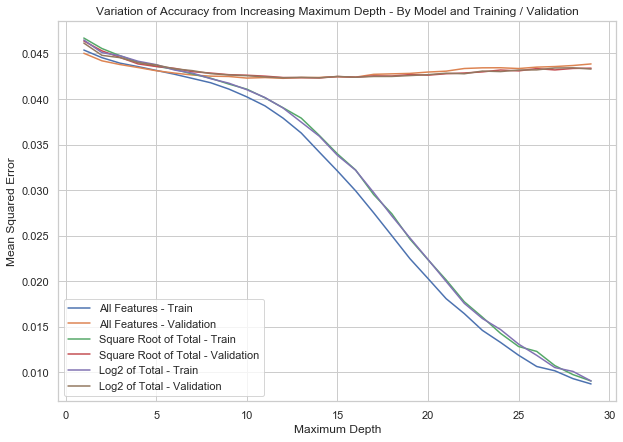

In [254]:
plt.figure(figsize=(10,7))
for n_features in ["All Features", "Square Root of Total", "Log2 of Total"]:
    new_frame = score_frame[score_frame["# of Features per Tree"] == n_features]
    plt.plot(new_frame['Maximum Tree Depth'],new_frame['Train MSE'], label=n_features + ' - Train')
    plt.plot(new_frame['Maximum Tree Depth'],new_frame['Validation MSE'], label=n_features + ' - Validation')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Mean Squared Error')
    plt.title("Variation of Accuracy from Increasing Maximum Depth - By Model and Training / Validation")
    plt.legend();

In [ ]:
# Conversely, we might try to use AdaBoosting, testing various tree depths

In [ ]:
# your code here
n_estimators = 300
best_iterations = []
for i in range(1,10):
    title = "Variation of Accuracy with Iterations - ADA Boost, Depth " + str(i)
    
    model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=i), 
                           n_estimators=n_estimators, 
                           learning_rate=0.05)
    model.fit(X_train, y_train)
    
    staged_train_predictions = np.array([p for p in model.staged_predict(X_train)])
    staged_test_predictions = np.array([p for p in model.staged_predict(X_test)])
    
    staged_errors = []
    
    for j in range(0, n_estimators):
        iteration_error = [j]

        iteration_error.append(mean_squared_error(y_train, staged_train_predictions[j,:]))
        iteration_error.append(mean_squared_error(y_test, staged_test_predictions[j,:]))
        
        staged_errors.append(iteration_error)
    
    error_frame = pd.DataFrame(staged_errors, columns = ['Iteration', 'Train MSE', 'Test MSE'])
    
    minimum_error = error_frame.sort_values(by="Test MSE", ascending=True).head(1)
    best_iteration = [i]
    best_iteration.append(minimum_error['Iteration'].values[0])
    best_iteration.append(minimum_error['Test MSE'].values[0])
    
    best_iterations.append(best_iteration)
    
    print(i)
    
    plt.figure(figsize=(6,4))
    plt.plot(error_frame['Iteration'], error_frame['Train MSE'], label='train')
    plt.plot(error_frame['Iteration'], error_frame['Test MSE'], label='test')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend();

In [141]:
pd.DataFrame(best_iterations, columns = ["Maximum Depth", "Iteration on which min MSE occurred", "Minimum MSE"]).sort_values(by = ['Minimum MSE'], ascending=True).head()

,Maximum Depth,Iteration on which min MSE occurred,Minimum MSE
2,3,9,0.020924
1,2,9,0.029394
0,1,8,0.042321
